<a href="https://colab.research.google.com/github/SaharKotb/ForgeryDetection/blob/main/Copy_of_Notebook_v1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Ignore Warnings

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import logging
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR)

## Data Acquisition

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PROJECT_PATH = "/content/drive/MyDrive/CNN Hyperparameters Optimization using Metaheuristic Optimizers"

In [ ]:
!pip install -q kaggle
import os
os.environ['KAGGLE_CONFIG_DIR'] = PROJECT_PATH

In [ ]:
%cd /content/drive/MyDrive/Github/

[Errno 2] No such file or directory: '/content/drive/MyDrive/Github/'
/content


In [ ]:
%cd /content/drive/MyDrive/CNN Hyperparameters Optimization using Metaheuristic Optimizers
!kaggle datasets download divg07/casia-20-image-tampering-detection-dataset

/content/drive/MyDrive/CNN Hyperparameters Optimization using Metaheuristic Optimizers
casia-20-image-tampering-detection-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip casia-20-image-tampering-detection-dataset.zip  

Streaming output truncated to the last 5000 lines.
  inflating: CASIA2/Tp/Tp_D_CRN_M_N_arc00045_arc00046_10084.tif  
  inflating: CASIA2/Tp/Tp_D_CRN_M_N_arc00045_arc00071_10087.tif  
  inflating: CASIA2/Tp/Tp_D_CRN_M_N_arc00046_arc00045_10083.tif  
  inflating: CASIA2/Tp/Tp_D_CRN_M_N_arc00054_cha00085_11922.jpg  
  inflating: CASIA2/Tp/Tp_D_CRN_M_N_arc00071_arc00045_10085.tif  
  inflating: CASIA2/Tp/Tp_D_CRN_M_N_arc00073_arc00072_10267.tif  
  inflating: CASIA2/Tp/Tp_D_CRN_M_N_arc00088_arc00064_10394.tif  
  inflating: CASIA2/Tp/Tp_D_CRN_M_N_art00012_art00013_11812.jpg  
  inflating: CASIA2/Tp/Tp_D_CRN_M_N_art00014_art00013_11836.jpg  
  inflating: CASIA2/Tp/Tp_D_CRN_M_N_art00058_art00049_10529.tif  
  inflating: CASIA2/Tp/Tp_D_CRN_M_N_art00067_ani00093_11801.jpg  
  inflating: CASIA2/Tp/Tp_D_CRN_M_N_art00067_ani00095_11803.jpg  
  inflating: CASIA2/Tp/Tp_D_CRN_M_N_art00067_ani00096_11802.jpg  
  inflating: CASIA2/Tp/Tp_D_CRN_M_N_art00067_nat00013_11804.jpg  
  inflating: CASIA2/Tp/Tp

## Configurations

In [ ]:
DATASET_PATH = "/content/drive/MyDrive/CNN Hyperparameters Optimization using Metaheuristic Optimizers/CASIA2"
CLASSES = ["Au", "Tp"]
NEW_SIZE = (300, 300, 3)
TRAIN_SIZE = 0.8
POPULATION_SIZE = 5
NO_OF_ITERATIONS = 3
LOWER_BOUND = 0.0
UPPER_BOUND = 1.0
EPOCHS = 15
PATIENCE = 7

## Helper Functions

In [ ]:
import matplotlib.pyplot as plt

def DisplayColorImage(image):
  newImage = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  f = plt.figure()
  plt.imshow(newImage)
  plt.show()
  plt.close()

def PlotHistory(history):
  f = plt.figure()
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title("Accuracy Curve")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend(["Train", "Validation"])
  plt.grid("both")
  plt.show()
  plt.close()

## Reading Dataset

In [ ]:
import cv2, os
X = []
y = []
counter = {"Au": 0, "Tp": 0}
for cls in CLASSES:
  clsContent = os.listdir(os.path.join(DATASET_PATH, cls))
  for imgName in clsContent:
    imgPath = os.path.join(DATASET_PATH, cls, imgName)
    image = cv2.imread(imgPath)
    try:
      image = cv2.resize(image, NEW_SIZE[:2], interpolation=cv2.INTER_CUBIC)
    except:
      print("Not available")
    X.append(image)
    y.append(cls)
    counter[cls] += 1

print(len(X), len(y))
print(counter)

Not available
Not available
Not available
12617 12617
{'Au': 7492, 'Tp': 5125}


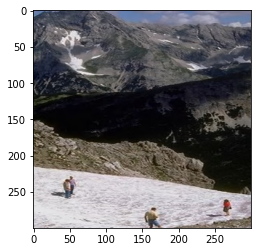

In [ ]:
DisplayColorImage(X[0])

## Dataset Balancing

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
dataGen = ImageDataGenerator(
  rotation_range=25,
  width_shift_range=0.2,
  height_shift_range=0.2,
  zoom_range=0.2,
  shear_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
)

## Label Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder
objEnc = LabelEncoder()
yEnc = objEnc.fit_transform(y)
print(y[0], yEnc[0])

Au 0


## Dataset Split

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
trainX, testX, trainY, testY = train_test_split(np.array(X), yEnc, train_size=TRAIN_SIZE, stratify=yEnc)
trainX, valX, trainY, valY = train_test_split(trainX, trainY, train_size=TRAIN_SIZE, stratify=trainY)
print(trainX.shape)
print(testX.shape)
print(valX.shape)

(8074,)
(2524,)
(2019,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


## Learning and Optimization

In [ ]:
from tensorflow.keras.optimizers import *

ranges = {
  "Rotation": np.arange(0, 31, 1),
  "Width Shift": np.arange(0, 0.21, 0.1),
  "Height Shift": np.arange(0, 0.21, 0.1),
  "Zoom": np.arange(0, 0.21, 0.1),
  "Shear": np.arange(0, 0.21, 0.1),
  "Horizontal Flip": [True, False],
  "Vertical Flip": [True, False],
  "Optimizer": [Adam(), Nadam(), RMSprop(), Adadelta(), Adagrad(), SGD()],
  "Batch Size": [8, 16, 32, 64],
  "TL Learn Ratio": np.arange(0, 26, 1),
}

SOLUTION_SIZE = len(ranges.keys())

In [ ]:
# Population Initialization
population = np.random.uniform(
  low=LOWER_BOUND,
  high=UPPER_BOUND,
  size=(POPULATION_SIZE, SOLUTION_SIZE)
)
print(population.shape)
print(population[0])

(5, 10)
[0.24240471 0.12030726 0.35283141 0.85812915 0.61567366 0.7109818
 0.49726582 0.56038681 0.27190151 0.49346553]


In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import *
from tensorflow.keras.callbacks import *
import numpy as np

# Fitness Function Evaluation
def FitnessFunction(solution):
  solution = np.round(solution, 4)

  index = int(np.round(solution[0] * (len(ranges["Rotation"]) - 1)))
  rotationValue = ranges["Rotation"][index]

  index = int(np.round(solution[1] * (len(ranges["Width Shift"]) - 1)))
  widthShiftValue = ranges["Width Shift"][index]

  index = int(np.round(solution[2] * (len(ranges["Height Shift"]) - 1)))
  heightShiftValue = ranges["Height Shift"][index]

  index = int(np.round(solution[3] * (len(ranges["Zoom"]) - 1)))
  zoomValue = ranges["Zoom"][index]

  index = int(np.round(solution[4] * (len(ranges["Shear"]) - 1)))
  shearValue = ranges["Shear"][index]

  index = int(np.round(solution[5] * (len(ranges["Horizontal Flip"]) - 1)))
  hFlipValue = ranges["Horizontal Flip"][index]

  index = int(np.round(solution[6] * (len(ranges["Vertical Flip"]) - 1)))
  vFlipValue = ranges["Vertical Flip"][index]

  index = int(np.round(solution[7] * (len(ranges["Optimizer"]) - 1)))
  optimizerValue = ranges["Optimizer"][index]

  index = int(np.round(solution[8] * (len(ranges["Batch Size"]) - 1)))
  batchSizeValue = ranges["Batch Size"][index]

  index = int(np.round(solution[9] * (len(ranges["TL Learn Ratio"]) - 1)))
  tlLearnRatioValue = ranges["TL Learn Ratio"][index]

  dataGen = ImageDataGenerator(
    rotation_range=rotationValue,
    width_shift_range=widthShiftValue,
    height_shift_range=heightShiftValue,
    zoom_range=zoomValue,
    shear_range=shearValue,
    horizontal_flip=hFlipValue,
    vertical_flip=vFlipValue,
  )

  baseModel = MobileNet(weights='imagenet', include_top=False, input_tensor=Input(NEW_SIZE))

  x = baseModel.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(1024, activation='relu')(x)
  predictions = Dense(1, activation='sigmoid')(x)

  model = Model(inputs=baseModel.input, outputs=predictions)

  for layer in baseModel.layers:
    layer.trainable = False

  fromIndex = int(np.round((len(baseModel.layers) - 1) * (1.0 - tlLearnRatioValue / 100.0)))
  for layer in baseModel.layers[fromIndex:]:
    layer.trainable = True

  model.compile(
    optimizer=optimizerValue, 
    loss='binary_crossentropy',
    metrics=["accuracy", Precision(), Recall(), AUC(), TruePositives(), TrueNegatives(), FalsePositives(), FalseNegatives()]
  )

  keyword = "MobileNet-" + "-".join([str(el)[2:] for el in solution])
  checkpointPath = os.path.join(PROJECT_PATH, "Checkpoints", keyword) + ".h5"
  csvLogPath = os.path.join(PROJECT_PATH, "Logs", keyword) + ".csv"

  histroy = model.fit(
    dataGen.flow(trainX, trainY, batch_size=batchSizeValue),
    validation_data=(valX, valY),
    batch_size=batchSizeValue,
    epochs=EPOCHS,
    verbose=0,
    callbacks=[
      ModelCheckpoint(checkpointPath, save_best_only=True, save_weights_only=True, monitor="val_accuracy", mode="max", verbose=0),
      TerminateOnNaN(),
      CSVLogger(csvLogPath, append=True),
      EarlyStopping(monitor="val_accuracy", mode="max", patience=PATIENCE),
    ]
  )

  PlotHistory(histroy)

  model.load_weights(checkpointPath)
  scoresList = model.evaluate(testX, testY, verbose=0)
  score = (scoresList[1] + scoresList[2] + scoresList[3]) / 3.0

  configs = [
    rotationValue,
    widthShiftValue,
    heightShiftValue,
    zoomValue,
    shearValue,
    hFlipValue,
    vFlipValue,
    optimizerValue._name,
    batchSizeValue,
    tlLearnRatioValue,
  ]
  print(scoresList, score, configs)

  return score

In [ ]:
# Population Updating
import numpy as np

def PopulationUpdating(population, scores, iterationNumber):
  bestIndex = np.argmax(scores)
  bestSolution = population[bestIndex].copy()
  bestScore = scores[bestIndex]

  # MRFO:
  # Write the metaheuristic rules for updating the population.
  newPopulation = population.copy()

  coef = iterationNumber / float(NO_OF_ITERATIONS)
  for i in range(len(population)):
    r = np.random.random(1)
    alpha = 2.0 * r * np.sqrt(np.abs(np.log(r)))
    r1 = np.random.random(1)
    factor = (NO_OF_ITERATIONS - iterationNumber + 1.0) / (NO_OF_ITERATIONS * 1.0)
    beta = 2.0 * np.exp(r1 * factor) * np.sin(2.0 * np.pi * r1)
    if (np.random.random(1) < 0.5):
      if (coef < np.random.random(1)):
        s = np.subtract(UPPER_BOUND, LOWER_BOUND)
        u = np.random.uniform(low=0, high=1, size=SOLUTION_SIZE)
        m = np.multiply(u, s)
        xRand = np.clip(np.add(LOWER_BOUND, m), LOWER_BOUND, UPPER_BOUND)
        if (i == 0):
          newPopulation[i, :] = xRand + r * (xRand - population[i, :]) + beta * (xRand - population[i, :])
        else:
          newPopulation[i, :] = xRand + r * (population[i - 1, :] - population[i, :]) + beta * (xRand - population[i, :])
      else:
        if (i == 0):
          newPopulation[i, :] = bestSolution + r * (bestSolution - population[i, :]) + beta * (bestSolution - population[i, :])
        else:
          newPopulation[i, :] = bestSolution + r * (population[i - 1, :] - population[i, :]) + beta * (bestSolution - population[i, :])
    else:
      if (i == 0):
        newPopulation[i, :] = population[i, :] + r * (bestSolution - population[i, :]) + alpha * (bestSolution - population[i, :])
      else:
        newPopulation[i, :] = population[i, :] + r * (population[i - 1, :] - population[i, :]) + alpha * (bestSolution - population[i, :])
    
    newPopulation[i, :] = np.clip(newPopulation[i, :], LOWER_BOUND, UPPER_BOUND)
    
    currentScore = FitnessFunction(newPopulation[i, :])
    if (currentScore > bestScore):
      bestSolution, bestScore = newPopulation[i, :].copy(), currentScore
    
    s = 2.0
    r2, r3 = np.random.random(1), np.random.random(1)
    newPopulation[i, :] = population[i, :] + s * (r2 * bestSolution - r3 * population[i, :])
    
    newPopulation[i, :] = np.clip(newPopulation[i, :], LOWER_BOUND, UPPER_BOUND)
    
    currentScore = FitnessFunction(newPopulation[i, :])
    if (currentScore > bestScore):
      bestSolution, bestScore = newPopulation[i, :].copy(), currentScore

  return newPopulation.copy()

In [ ]:
# Repeat
bestSolutions = []
bestScores = []
for iterationNumber in range(NO_OF_ITERATIONS):
  scores = []
  for i in range(len(population)):
    score = FitnessFunction(population[i])
    scores.append(score)

  newPopulation = PopulationUpdating(population, scores, iterationNumber)
  
  # LOGGING THE DATA
  populationScoresPath = os.path.join(PROJECT_PATH, "Population.csv")
  # T #, S #, ......, Score
  file = open(populationScoresPath, "a")
  for i in range(len(population)):
    data = f"{iterationNumber + 1},{i + 1},"
    data += ",".join([str(el) for el in population[i]])
    data += f",{scores[i]}"
    data += "\n"
    file.write(data)
  file.close()

  bestIndex = np.argmax(scores)
  bestSolution = population[bestIndex].copy()
  bestScore = scores[bestIndex]
  bestSolutions.append(bestSolution)
  bestScores.append(bestScore)
  
  population = newPopulation.copy()

ValueError: ignored

In [ ]:
# LOGGING THE DATA
bestSolutionsPath = os.path.join(PROJECT_PATH, "BestSolutions.csv")
file = open(bestSolutionsPath, "w")
for i in range(len(bestSolutions)):
  data = ",".join([str(el) for el in bestSolutions[i]])
  data += f",{bestScores[i]}"
  data += "\n"
  file.write(data)
file.close()